In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
sns.set()
# from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# from sklearn.linear_model import Lasso, Ridge, LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error, r2_score

In [2]:
processed_data = pd.read_csv('data_processed.csv')

In [3]:
df = processed_data.copy()

In [4]:
df.head(100)

,Age,Gender,Education Level,Job Title_0,Job Title_1,Job Title_2,Job Title_3,Job Title_4,Job Title_5,Job Title_6,Job Title_7,Years of Experience,Salary
0,32.0,1.0,2,0,0,0,0,0,0,0,1,5.0,90000.0
1,28.0,0.0,3,0,0,0,0,0,0,1,0,3.0,65000.0
2,45.0,1.0,4,0,0,0,0,0,0,1,1,15.0,150000.0
3,36.0,0.0,2,0,0,0,0,0,1,0,0,7.0,60000.0
4,52.0,1.0,3,0,0,0,0,0,1,0,1,20.0,200000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,39.0,0.0,2,0,1,0,1,0,0,0,1,12.0,65000.0
96,47.0,1.0,4,0,1,0,1,0,0,1,0,22.0,160000.0
97,26.0,1.0,2,0,1,0,1,0,0,1,1,1.0,35000.0
98,38.0,0.0,3,0,1,0,1,0,1,0,0,10.0,90000.0


In [5]:
df.columns.values

array(['Age', 'Gender', 'Education Level', 'Job Title_0', 'Job Title_1',
       'Job Title_2', 'Job Title_3', 'Job Title_4', 'Job Title_5',
       'Job Title_6', 'Job Title_7', 'Years of Experience', 'Salary'],
      dtype=object)

#### **I tried different type of transformation on the Salary (Boxcox, log) but it still does not ressemble a normal distribution. For that reason alone, I will not do a Linear Regression but a Random Forest and I will later compare it with an XGBoost Model**

In [6]:
X = df.drop('Salary', axis = 1)
y = df[['Salary']]

In [7]:
X.isna().sum()

Age                    0
Gender                 0
Education Level        0
Job Title_0            0
Job Title_1            0
Job Title_2            0
Job Title_3            0
Job Title_4            0
Job Title_5            0
Job Title_6            0
Job Title_7            0
Years of Experience    0
dtype: int64

#### **No scaling is then need for the next step**

In [8]:
# scaler =  StandardScaler()
# scaled_X = scaler.fit_transform(X)

#### **Splitting the data**

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=365)

In [10]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(5347, 12)
(5347, 1)
(1337, 12)
(1337, 1)


In [11]:
y_train.isna().sum()

Salary    0
dtype: int64

In [12]:
model_rfr = RandomForestRegressor(n_estimators=100, max_depth=30, n_jobs=2)
results = model_rfr.fit(X_train, y_train)
results

c:\Users\spenc\anaconda3\envs\ds_ml_env\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(max_depth=30, n_jobs=2)

In [13]:
pred_ = model_rfr.predict(X_test)

In [14]:
mse = mean_squared_error(pred_, y_test)
r2 = r2_score(pred_ , y_test)
print(f"RMSE: {mse**0.5:.2f}, R²: {r2*100:.2f}%")

RMSE: 8855.26, R²: 97.12%


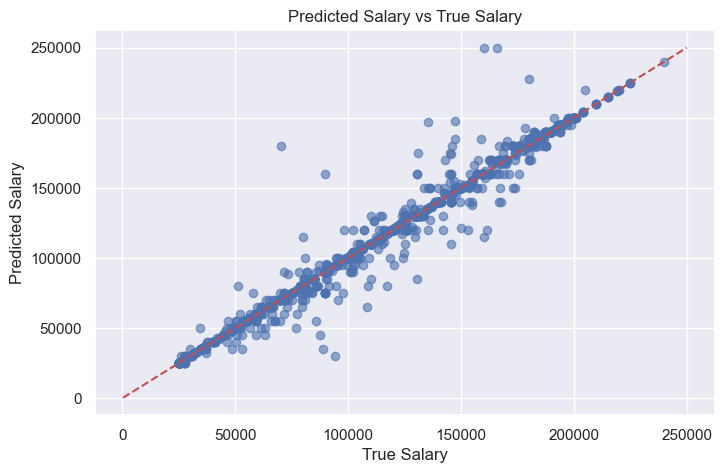

In [15]:
plt.figure(figsize=(8,5))
plt.scatter(pred_, y_test, alpha=0.6)
plt.xlabel('True Salary')
plt.ylabel('Predicted Salary')
plt.title('Predicted Salary vs True Salary')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # perfect prediction line
plt.savefig('plots/Predicted vs Actual Salary.png')
plt.show()


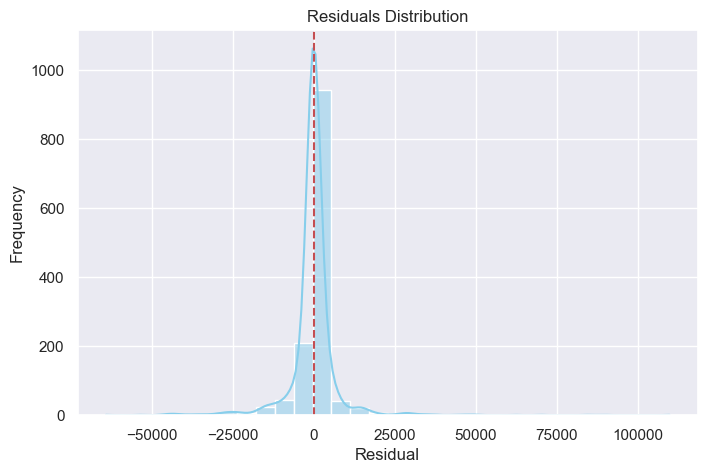

In [16]:
# Ensure residuals are computed correctly
y_test_arr = y_test.to_numpy().flatten()
pred_arr = np.array(pred_).flatten()
min_len = min(len(y_test_arr), len(pred_arr))
residuals = y_test_arr[:min_len] - pred_arr[:min_len]

# Plot residual distribution
plt.figure(figsize=(8,5))
sns.histplot(residuals, bins=30, kde=True, color='skyblue')
plt.axvline(0, color='r', linestyle='--')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')
plt.show()


In [17]:
feat_imp = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model_rfr.feature_importances_
}).sort_values(by='Importance', ascending=False)
print(feat_imp)


                Feature  Importance
11  Years of Experience    0.758150
0                   Age    0.059255
2       Education Level    0.034476
6           Job Title_3    0.027280
7           Job Title_4    0.023887
8           Job Title_5    0.020536
10          Job Title_7    0.020189
4           Job Title_1    0.014030
3           Job Title_0    0.013105
9           Job Title_6    0.011926
5           Job Title_2    0.009035
1                Gender    0.008130


In [18]:
def evaluate_model(model, X_train, y_train, X_test, y_test, feature_names=None):
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Metrics (manual RMSE)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    r2_train = r2_score(y_train, y_train_pred)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    r2_test = r2_score(y_test, y_test_pred)

    print(f"Train RMSE: {rmse_train:.2f}, R²: {r2_train:.2f}")
    print(f"Test RMSE: {rmse_test:.2f}, R²: {r2_test:.2f}")

    # Residuals
    residuals = y_test.values.flatten() - y_test_pred.flatten()

    # Residual plot
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.scatter(y_test_pred, residuals, alpha=0.6)
    plt.axhline(0, color='r', linestyle='--')
    plt.xlabel('Predicted')
    plt.ylabel('Residuals')
    plt.title('Residuals vs Predicted')
    plt.savefig('plots/Residuals vs Predicted.png')

    # Residual distribution
    plt.subplot(1,2,2)
    sns.histplot(residuals, bins=30, kde=True, color='skyblue')
    plt.axvline(0, color='r', linestyle='--')
    plt.xlabel('Residual')
    plt.ylabel('Frequency')
    plt.title('Residuals Distribution')
    plt.tight_layout()
    plt.savefig('plots/Residuals Distribution.png')
    plt.show()

    # Feature importance (if applicable)
    if hasattr(model, 'feature_importances_') and feature_names is not None:
        importances = model.feature_importances_
        fi_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
        fi_df = fi_df.sort_values('Importance', ascending=False)

        plt.figure(figsize=(8,5))
        sns.barplot(x='Importance', y='Feature', data=fi_df, palette='viridis')
        plt.title('Feature Importance')
        plt.savefig('plots/Feature Importance.png')
        plt.show()


Train RMSE: 5232.78, R²: 0.99
Test RMSE: 8855.26, R²: 0.97


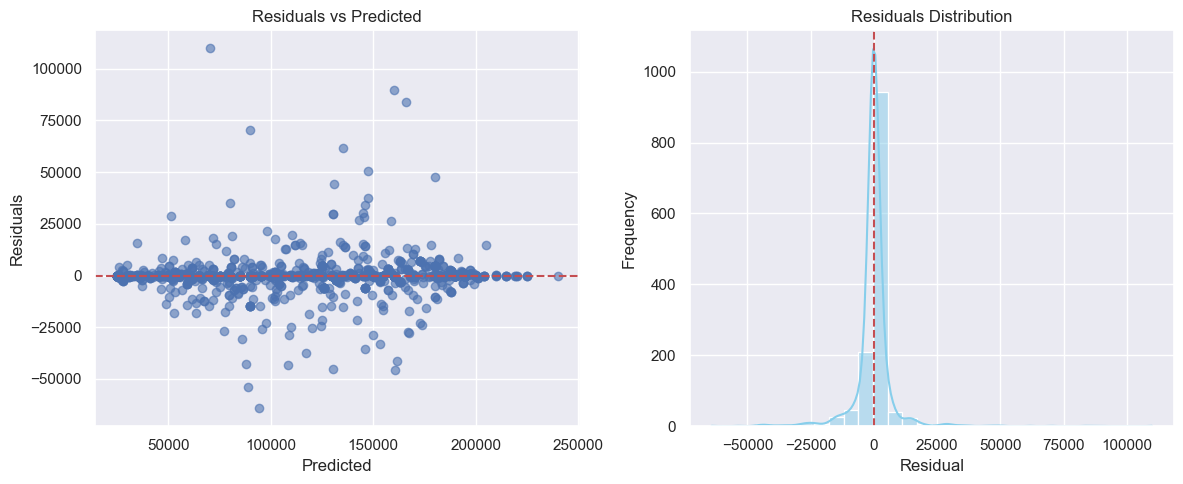

C:\Users\spenc\AppData\Local\Temp\ipykernel_1820\3703577052.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=fi_df, palette='viridis')


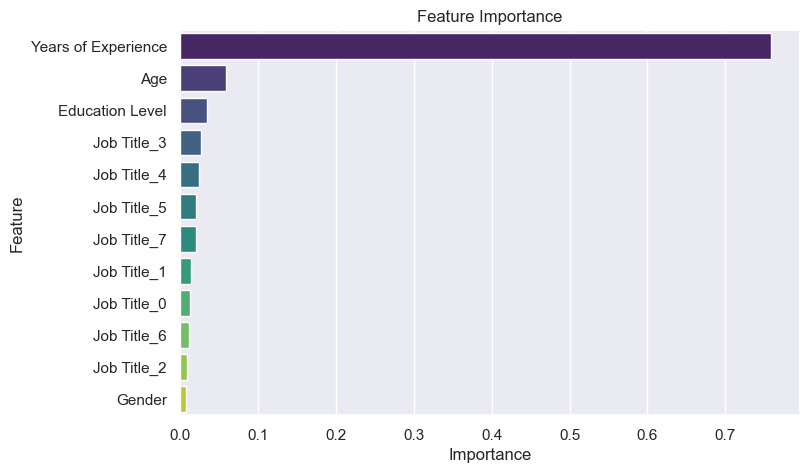

In [19]:
evaluate_model(model_rfr, X_train, y_train, X_test, y_test, feature_names=X_train.columns)


In [20]:
import joblib
import os
os.makedirs('models', exist_ok=True)
# Save the model
joblib.dump(model_rfr, 'models/random_forest_salary.pkl')
print("✅ Model saved to 'models/random_forest_salary.pkl'")

# To load it later
# loaded_model = joblib.load('models/random_forest_salary.pkl')

✅ Model saved to 'models/random_forest_salary.pkl'


In [21]:
# Synthetic data
synthetic_data = pd.DataFrame({
    'Age': [28, 45, 33],
    'Gender': [1, 0, 1],               
    'Education Level': [3, 2, 4],
    'Job Title_0': [0, 1, 0],
    'Job Title_1': [1, 0, 0],
    'Job Title_2': [0, 0, 1],
    'Job Title_3': [0, 0, 0],
    'Job Title_4': [0, 0, 0],
    'Job Title_5': [0, 0, 0],
    'Job Title_6': [0, 0, 0],
    'Job Title_7': [0, 0, 0],
    'Years of Experience': [5, 20, 10]
})

# Predict with your trained model
predicted_salary = model_rfr.predict(synthetic_data)
synthetic_data['Predicted_Salary'] = predicted_salary

synthetic_data


,Age,Gender,Education Level,Job Title_0,Job Title_1,Job Title_2,Job Title_3,Job Title_4,Job Title_5,Job Title_6,Job Title_7,Years of Experience,Predicted_Salary
0,28,1,3,0,1,0,0,0,0,0,0,5,82806.170000
1,45,0,2,1,0,0,0,0,0,0,0,20,145905.109833
2,33,1,4,0,0,1,0,0,0,0,0,10,158987.749095
